# Subgraph Matching and Counting

In [1]:
import pandas as pd
import networkx as nx
import os
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import statistics as sts
from networkx.algorithms import isomorphism
import itertools
import random

## Functions

### Function to Plot Graphs

In [2]:
def plot_graph(graph):
    """Plots a directed graph."""
    pos = nx.spring_layout(graph, seed=42)  # Positions for all nodes
    nx.draw(graph, pos, with_labels=True, node_size=300, node_color="skyblue", font_size=10, arrowsize=10)
    plt.show()

### Graph Statistics

In [3]:
def show_graph_stats(G):
    triangles = nx.triangles(G).values()
    degrees = dict(nx.degree(G)).values()
    number_of_nodes = G.number_of_nodes()

    try:
        average_clustering = nx.average_clustering(G)
    except:
        average_clustering = 0

    # try catch for core
    try:
        core = nx.core_number(G)
    except:
        core = 0

    print("Nodes: ", 
          number_of_nodes)
    print("Edges: ", 
          G.number_of_edges())
    print("Density: ", 
          nx.density(G))
    print("Max degree: ", 
          max(degrees))
    print("Min degree: ", 
          min(degrees))
    print("Average degree: ", 
          sts.mean(degrees))
    print("Assortativity: ", 
          nx.degree_assortativity_coefficient(G))
    print("Number of triangles: ", 
          sum(triangles) / 3)
    print("Average number of triangles: ", 
          average_clustering * number_of_nodes)
    print("Average clustering: ", 
          average_clustering)
    print("Maximum number of triangles: ", 
          max(triangles))
    print("Average clustering coefficient: ", 
          average_clustering)
    print("Fraction of closed triangles: ", 
          nx.transitivity(G))
    print("Maximum k-core: ", 
          max(core.values()))

### Read Graphs from File

In [4]:
def read_graph_from_edge_list(file_path):
    """Reads a directed graph from an edge list file."""
    G = nx.DiGraph()
    with open(file_path, 'r') as file:
        for line in file:
            edge = line.strip().split()
            if len(edge) == 2:
                source, target = edge
                G.add_edge(source, target)
    return G

### Subgraph Matching and Counting

In [5]:
def generate_subgraphs(graph, size):
    """
    Generate all subgraphs of a given size from a graph.

    Parameters:
        graph (NetworkX graph): The input graph from which subgraphs are generated.
        size (int): The size of subgraphs to generate (number of nodes).

    Returns:
        list: List of subgraphs of the specified size.
    """
    print("Generating subgraphs of size", size)
    subgraphs = []
    for nodes in itertools.combinations(graph.nodes(), size):
        # guarantee that there is no isolated node
        subgraph = graph.subgraph(nodes)
        if nx.is_weakly_connected(subgraph):
            subgraphs.append(subgraph)


    print("Generated", len(subgraphs), "subgraphs")
    return subgraphs

In [6]:
def subgraph_count(graph, motifs):
    """
    Count the occurrences of a list of subgraphs within a given graph.

    Parameters:
        graph (NetworkX graph): The input graph in which occurrences are counted.
        motifs (list): List of subgraphs whose occurrences are being counted.

    Returns:
        dict: A dictionary containing the counts of occurrences for each motif.
    """
    # Generate all subgraphs of the largest size in the list of motifs
    max_size = max([subgraph.number_of_nodes() for subgraph in motifs])
    all_subgraphs = generate_subgraphs(graph, max_size)

    # Initialize a dictionary to store counts for each motif
    motif_counts = {i: 0 for i, motif in enumerate(motifs)}

    # Iterate through all subgraphs and motifs to count occurrences
    for subgraph in all_subgraphs:
        for i, motif in enumerate(motifs):
            if len(subgraph.edges()) == len(motif.edges()):   
                if nx.is_isomorphic(subgraph, motif):
                    motif_counts[i] += 1

    return motif_counts

### Generate Sample from Graph

In [7]:
def generate_sample_graph(original_graph, sample_size):
    """
    Generates a random sample of a graph.

    Parameters:
        original_graph (NetworkX graph): The input graph to sample from.
        sample_size (int): The number of nodes to sample.

    Returns:
        NetworkX graph: A random sample of the input graph.
    """

    sample_graph = nx.DiGraph() if original_graph.is_directed() else nx.Graph()

    # Convert nodes to list for compatibility with random.sample
    nodes_list = list(original_graph.nodes())

    # Sample nodes
    sample_nodes = random.sample(nodes_list, min(sample_size, len(original_graph)))
    sample_graph.add_nodes_from(sample_nodes)

    # Sample edges
    for u, v in original_graph.edges():
        if u in sample_nodes and v in sample_nodes:
            sample_graph.add_edge(u, v)

    return sample_graph

### Generate Configuration Model

In [8]:
def generate_configuration_model_graph(original_graph, seed):
    """
    Generate a random graph using the configuration model while preserving the properties of an existing graph.

    Ignore any self-loops or parallel edges in the original graph.

    Parameters:
    - original_graph: NetworkX graph object

    Returns:
    - random_graph: Random graph with properties preserved from the existing graph
    """
    
    # If the existing graph is directed, ensure the generated graph is directed as well
    if original_graph.is_directed():
        in_degree = dict(original_graph.in_degree())
        out_degree = dict(original_graph.out_degree())
        random_graph = nx.directed_configuration_model(in_degree.values(), out_degree.values(), seed=seed)
    else:
        degree = dict(original_graph.degree())
        random_graph = nx.configuration_model(degree.values(), seed=seed)

    # Adjust any additional properties of the generated graph to match those of the existing graph
    # Update node attributes only for nodes that exist in both graphs
    common_nodes = set(original_graph.nodes()).intersection(random_graph.nodes())
    for node in common_nodes:
        random_graph.nodes[node].update(original_graph.nodes[node])

    # remove self loops
    random_graph.remove_edges_from(nx.selfloop_edges(random_graph))
    
    # Add edges between separated components until the graph becomes connected
    if original_graph.is_directed():
        while not nx.is_weakly_connected(random_graph):
            # Find the weakly connected components
            components = list(nx.weakly_connected_components(random_graph))

            # Add an edge between a random node in each component
            node1 = list(components[0])[0]
            node2 = list(components[1])[0]
            random_graph.add_edge(node1, node2)
    else:
        while not nx.is_connected(random_graph):
            # Find the connected components
            components = list(nx.connected_components(random_graph))

            # Add an edge between a random node in each component
            node1 = list(components[0])[0]
            node2 = list(components[1])[0]
            random_graph.add_edge(node1, node2)

    return random_graph


## Main Tests

### Read Motif Files

In [9]:
# Directory containing the edge list files
directory = '../data/motifs/'

# List to store the graphs
motifs = []

# Iterate over each file in the directory
for i in range(1, 14):  # Assuming files are named file1.edges, file2.edges, ..., file13.edges
    file_name = f"motif{i}.edges"
    file_path = os.path.join(directory, file_name)
    if os.path.exists(file_path):
        # Read the graph from the edge list file
        motif = read_graph_from_edge_list(file_path)
        motifs.append(motif)
        print(f"Graph {i} added to the list.")
    else:
        print(f"File {file_name} not found.")

Graph 1 added to the list.
Graph 2 added to the list.
Graph 3 added to the list.
Graph 4 added to the list.
Graph 5 added to the list.
Graph 6 added to the list.
Graph 7 added to the list.
Graph 8 added to the list.
Graph 9 added to the list.
Graph 10 added to the list.
Graph 11 added to the list.
Graph 12 added to the list.
Graph 13 added to the list.


Show motifs

Plotting motif 1


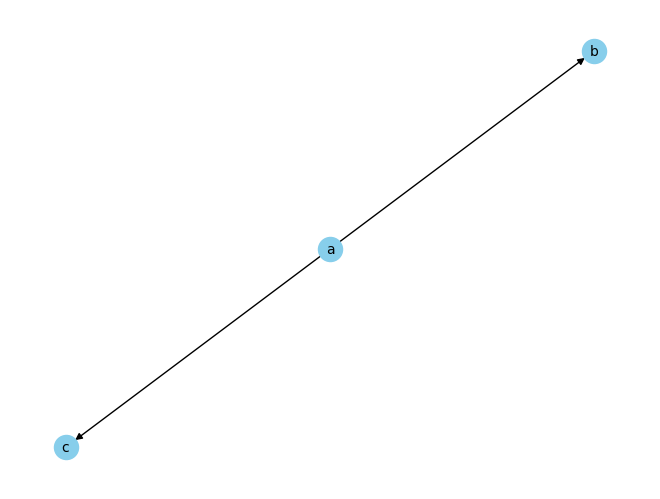

Plotting motif 2


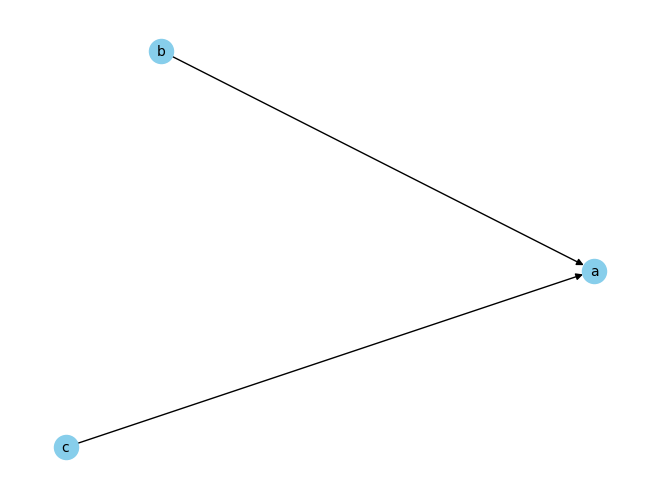

Plotting motif 3


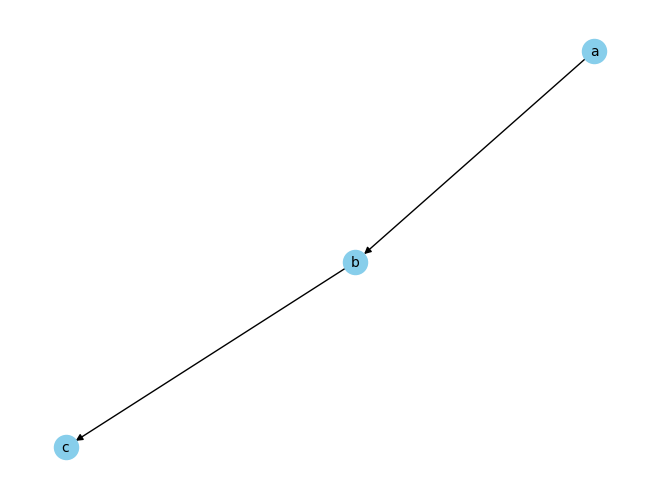

Plotting motif 4


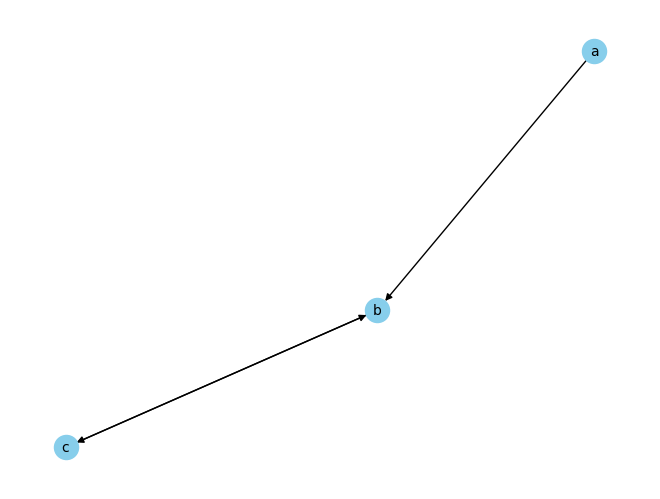

Plotting motif 5


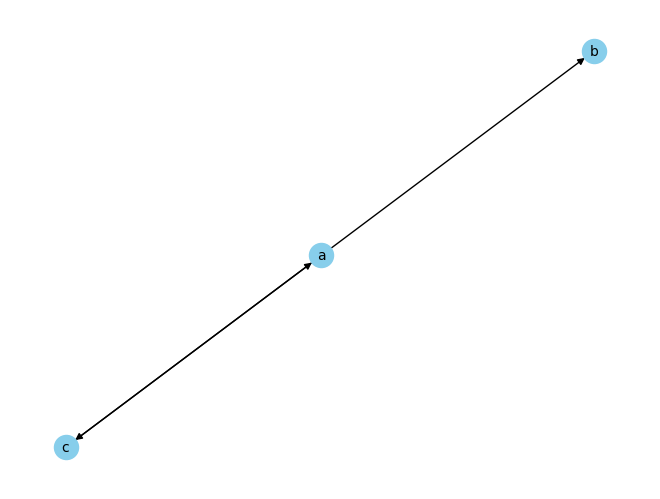

Plotting motif 6


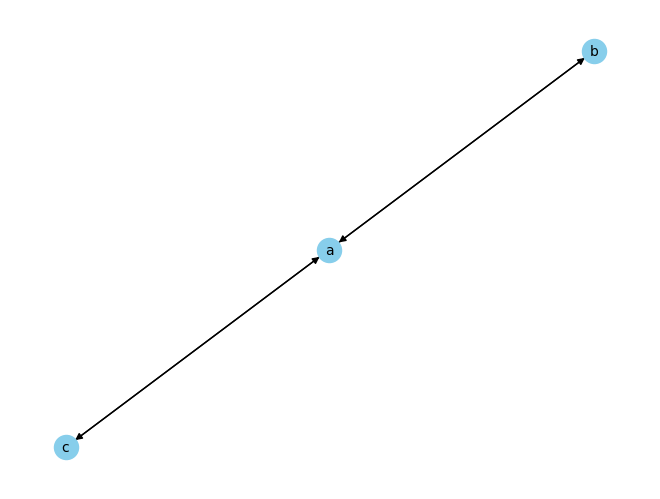

Plotting motif 7


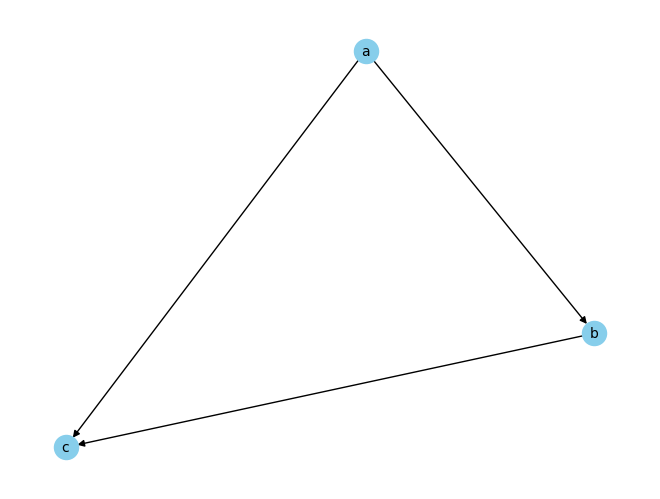

Plotting motif 8


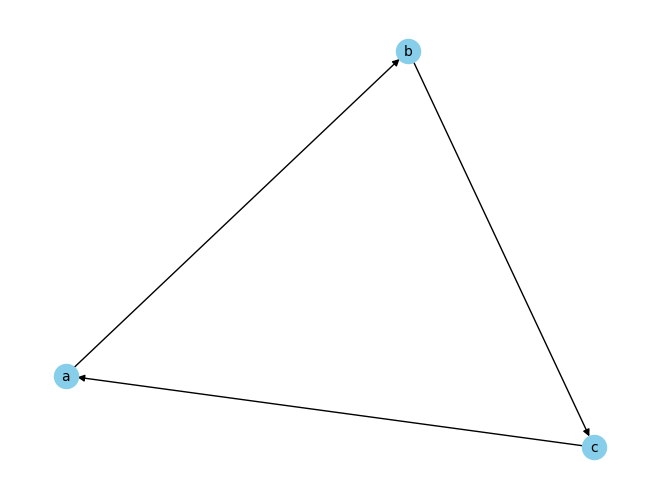

Plotting motif 9


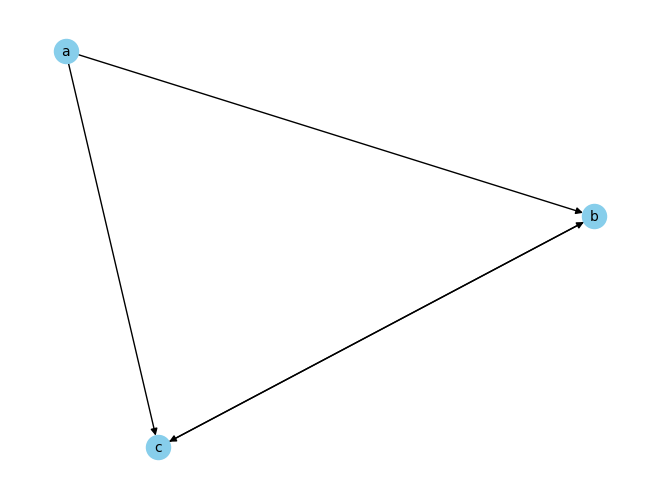

Plotting motif 10


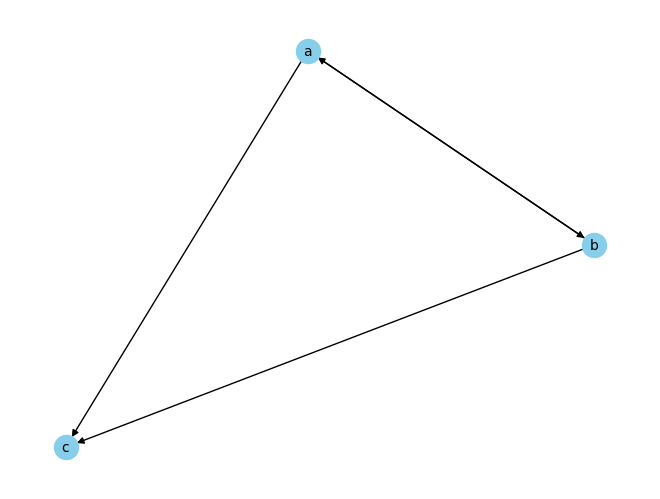

Plotting motif 11


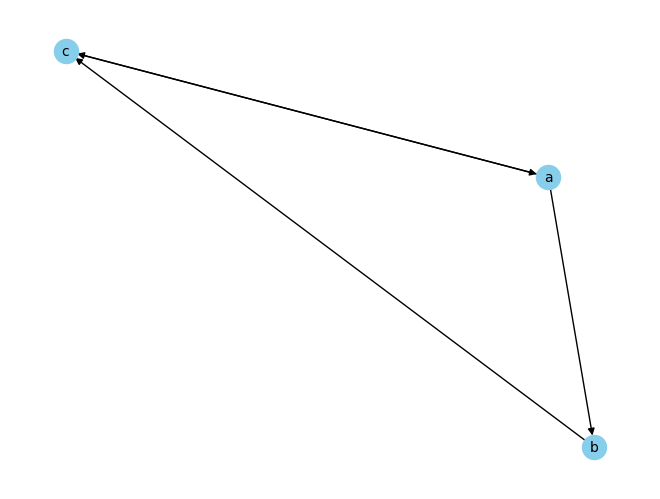

Plotting motif 12


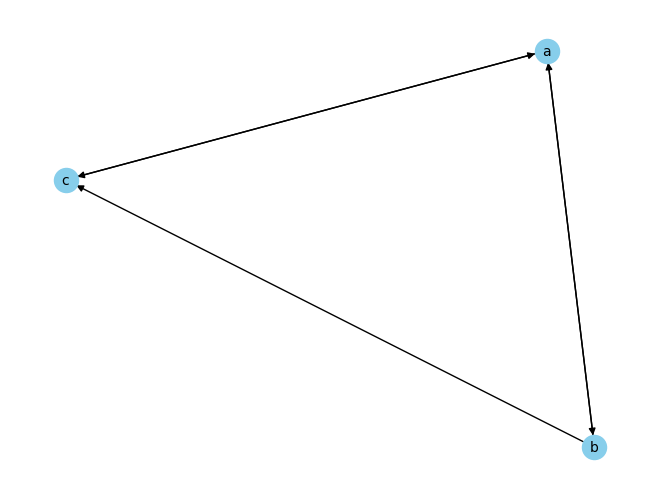

Plotting motif 13


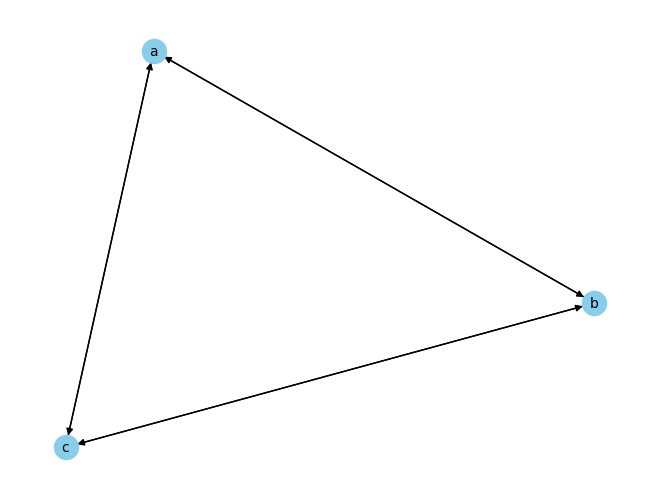

In [10]:
for idx, graph in enumerate(motifs):
    print(f"Plotting motif {idx+1}")
    plot_graph(graph)

### Read Real-World Graph

In [11]:
real_world_graph = read_graph_from_edge_list('../data/tests/synthetic1.edges')

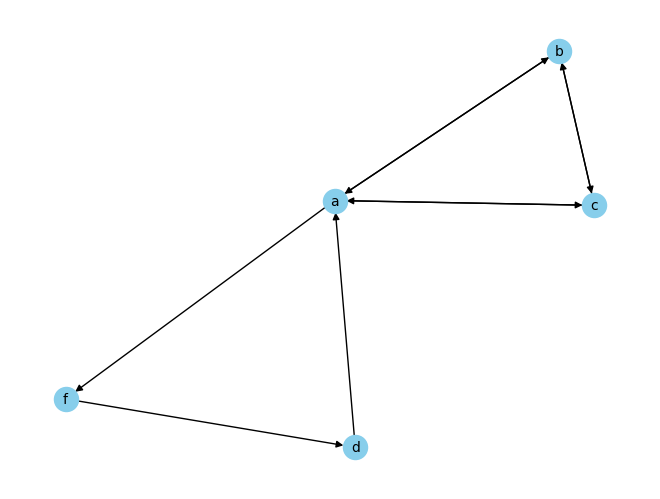

In [12]:
plot_graph(real_world_graph)

In [13]:
# counts = subgraph_count(real_world_graph, motifs)
# for i, count in counts.items():
    # print(f"Subgraph {i+1} count: {count}")

### Count Subgraphs to Find Motifs in Real-World Graph

In [14]:
counts = subgraph_count(real_world_graph, motifs)

Generating subgraphs of size 3
Generated 6 subgraphs


In [15]:
# show the subgraph counts in a pandas dataframe
df = pd.DataFrame(counts.items(), columns=['Motif', 'Count'])
df['Motif'] = df['Motif'] + 1
df.index = df['Motif']
df.drop(columns='Motif', inplace=True)
df

,Count
Motif,
1,0
2,0
3,0
4,2
5,2
6,0
7,0
8,1
9,0


### Generate Random Graphs With Configuration Model

Generate a list of 10 random graphs using the configuration model

In [16]:
# Generate the seed list for the configuration model
seed_list = [i for i in range(10)]

# With the same degree sequence as the Twitter graph
random_graphs = [generate_configuration_model_graph(real_world_graph, seed_list[i]) 
                 for i in range(10)]

Plotting random graph 1


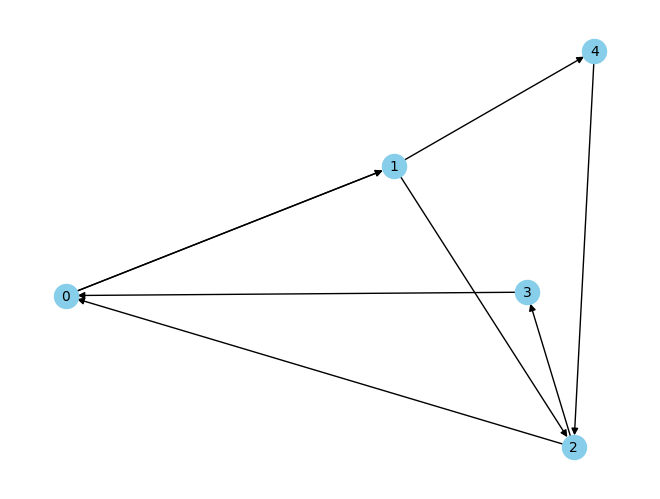

Plotting random graph 2


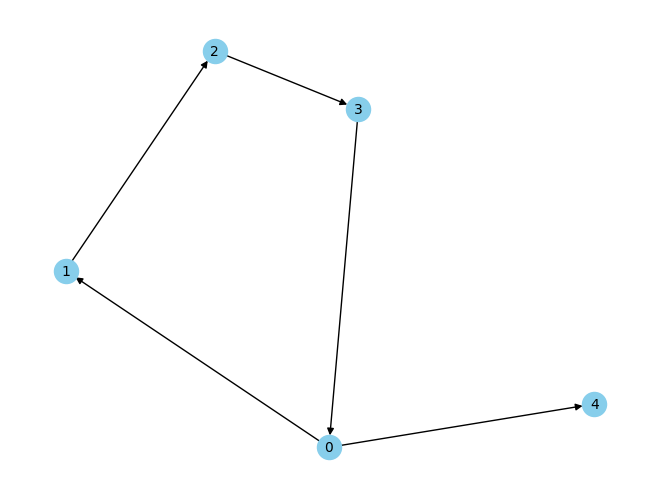

Plotting random graph 3


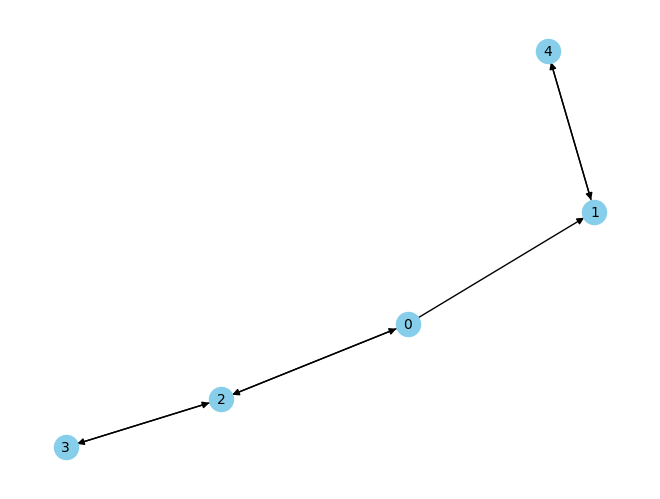

Plotting random graph 4


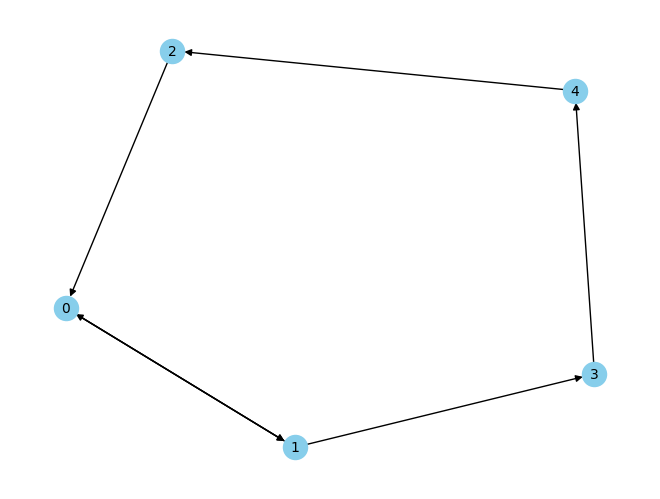

Plotting random graph 5


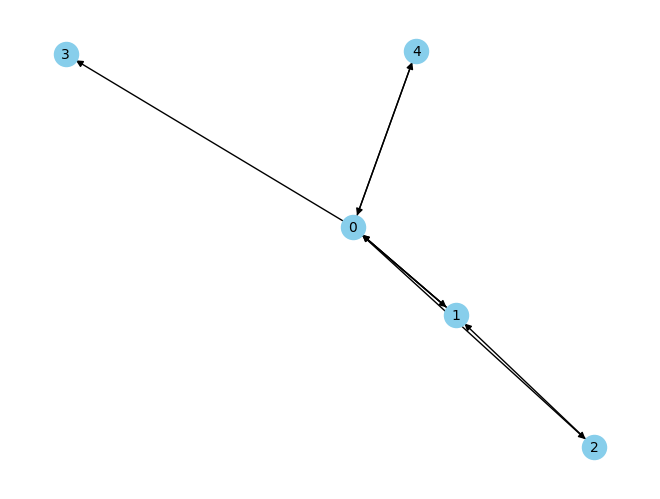

Plotting random graph 6


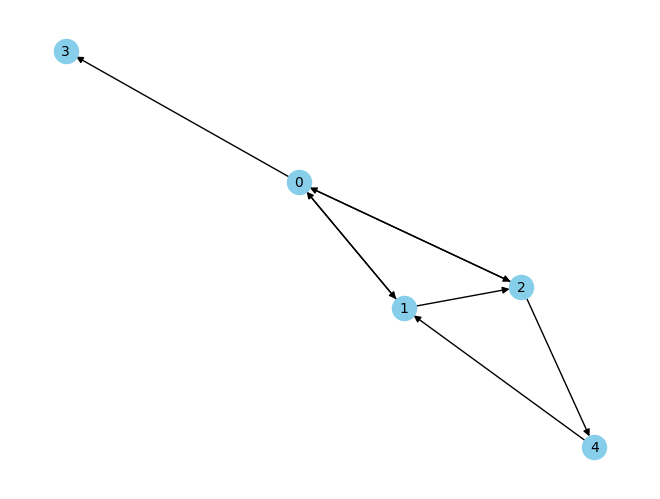

Plotting random graph 7


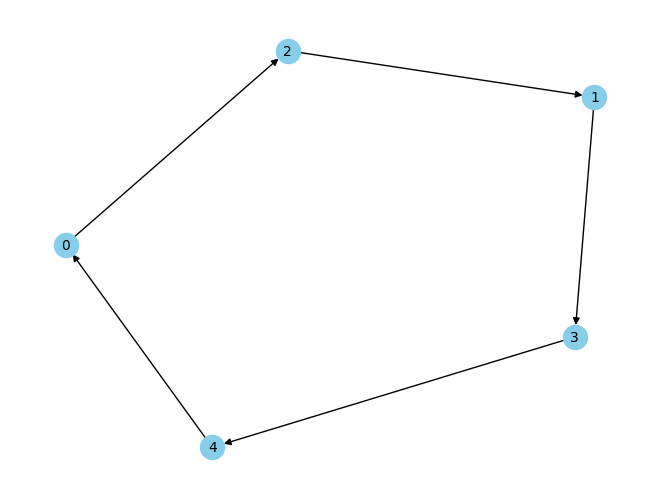

Plotting random graph 8


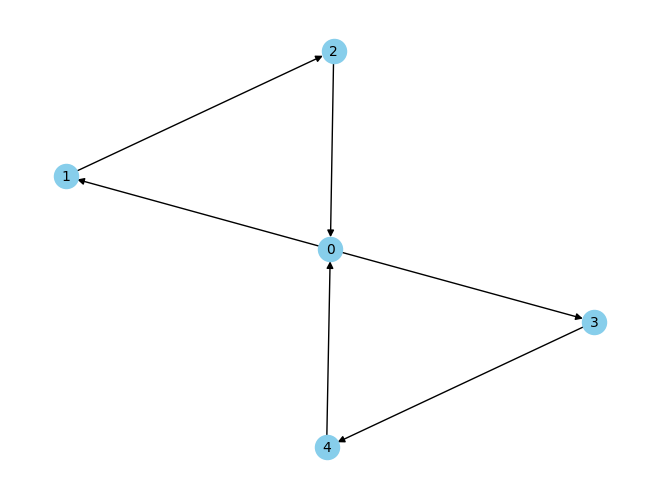

Plotting random graph 9


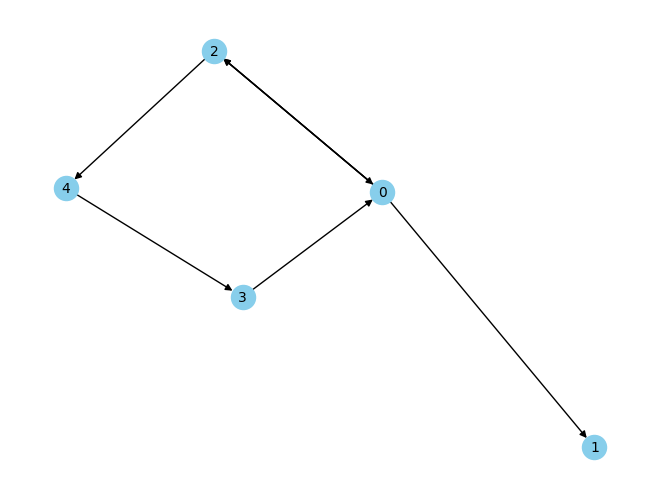

Plotting random graph 10


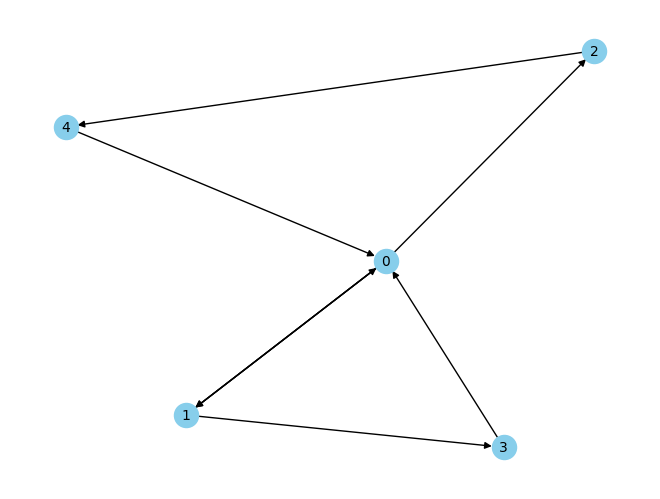

In [17]:
# plot the random graphs
for idx, graph in enumerate(random_graphs):
    print(f"Plotting random graph {idx+1}")
    plot_graph(graph)

count subgraphs in random graphs

In [18]:
# Calculate the counts of subgraphs in each random graph
random_graph_counts = [subgraph_count(graph, motifs) for graph in random_graphs]

Generating subgraphs of size 3
Generated 8 subgraphs
Generating subgraphs of size 3
Generated 6 subgraphs
Generating subgraphs of size 3
Generated 3 subgraphs
Generating subgraphs of size 3
Generated 5 subgraphs
Generating subgraphs of size 3
Generated 6 subgraphs
Generating subgraphs of size 3
Generated 6 subgraphs
Generating subgraphs of size 3
Generated 5 subgraphs
Generating subgraphs of size 3
Generated 6 subgraphs
Generating subgraphs of size 3
Generated 6 subgraphs
Generating subgraphs of size 3
Generated 6 subgraphs


### Results

In [19]:
# show the counts of subgraphs in each random graph in a pandas dataframe 
df = pd.DataFrame(random_graph_counts)

# rename the columns to the motif numbers
df.columns = [f"motif{i+1}" for i in range(len(motifs))]

df

,motif1,motif2,motif3,motif4,motif5,motif6,motif7,motif8,motif9,motif10,motif11,motif12,motif13
0,0,0,3,0,0,0,2,0,0,0,0,0,0
1,1,0,5,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,1,1,0,0,0,0,0,0,0
3,0,0,3,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,2,0,0,0,0,0,0,0,0
5,0,0,0,1,3,0,0,1,0,0,0,1,0
6,0,0,5,0,0,0,0,0,0,0,0,0,0
7,1,1,2,0,0,0,0,2,0,0,0,0,0
8,0,0,3,0,0,0,0,0,0,0,0,0,0
9,0,1,1,0,0,0,0,1,0,0,0,0,0


calculate the average of subgraph counts in random graphs

In [20]:
average_counts = {
    i: sts.mean([counts[i] for counts in random_graph_counts])
    for i in range(len(motifs))
}

for i, count in average_counts.items():
    print(f"Subgraph {i+1} average count: {count}")

Subgraph 1 average count: 0.3
Subgraph 2 average count: 0.2
Subgraph 3 average count: 2.2
Subgraph 4 average count: 0.2
Subgraph 5 average count: 0.6
Subgraph 6 average count: 0.1
Subgraph 7 average count: 0.2
Subgraph 8 average count: 0.4
Subgraph 9 average count: 0
Subgraph 10 average count: 0
Subgraph 11 average count: 0
Subgraph 12 average count: 0.1
Subgraph 13 average count: 0


calculate the standard deviation of subgraph counts in random graphs

In [21]:
std_dev_counts = {
    i: sts.stdev([counts[i] for counts in random_graph_counts])
    for i in range(len(motifs))
}

for i, count in std_dev_counts.items():
    print(f"Subgraph {i+1} standard deviation: {count}")

Subgraph 1 standard deviation: 0.48304589153964794
Subgraph 2 standard deviation: 0.4216370213557839
Subgraph 3 standard deviation: 1.9321835661585918
Subgraph 4 standard deviation: 0.4216370213557839
Subgraph 5 standard deviation: 1.0749676997731399
Subgraph 6 standard deviation: 0.31622776601683794
Subgraph 7 standard deviation: 0.6324555320336759
Subgraph 8 standard deviation: 0.699205898780101
Subgraph 9 standard deviation: 0.0
Subgraph 10 standard deviation: 0.0
Subgraph 11 standard deviation: 0.0
Subgraph 12 standard deviation: 0.31622776601683794
Subgraph 13 standard deviation: 0.0


Calculate the Z-score of subgraph counts in real-world graph

In [22]:
z_scores = {}
for i in range(len(motifs)):
    if std_dev_counts[i] != 0:
        z_scores[i] = (counts[i] - average_counts[i]) / std_dev_counts[i]
    else:
        # Handle the case when standard deviation is zero
        z_scores[i] = float('nan')  # or any other value you prefer

for i, z_score in z_scores.items():
    print(f"Subgraph {i+1} z-score: {z_score}")

Subgraph 1 z-score: -0.6210590034081188
Subgraph 2 z-score: -0.47434164902525694
Subgraph 3 z-score: -1.1386081729148845
Subgraph 4 z-score: 4.2690748412273125
Subgraph 5 z-score: 1.302364713186689
Subgraph 6 z-score: -0.31622776601683794
Subgraph 7 z-score: -0.31622776601683794
Subgraph 8 z-score: 0.8581163303210331
Subgraph 9 z-score: nan
Subgraph 10 z-score: nan
Subgraph 11 z-score: nan
Subgraph 12 z-score: -0.31622776601683794
Subgraph 13 z-score: nan


In [23]:
# generate data frame with average counts, standard deviation and z-scores
motif_df = pd.DataFrame({
    'Motif': list(average_counts.keys()),
    'Average Count': list(average_counts.values()),
    'Standard Deviation': list(std_dev_counts.values()),
    'Z-Score': list(z_scores.values())
})

motif_df['Motif'] = motif_df['Motif'] + 1
motif_df.index = motif_df['Motif']
motif_df.drop(columns='Motif', inplace=True)

In [24]:
motif_df

,Average Count,Standard Deviation,Z-Score
Motif,,,
1,0.3,0.483046,-0.621059
2,0.2,0.421637,-0.474342
3,2.2,1.932184,-1.138608
4,0.2,0.421637,4.269075
5,0.6,1.074968,1.302365
6,0.1,0.316228,-0.316228
7,0.2,0.632456,-0.316228
8,0.4,0.699206,0.858116
9,0.0,0.000000,NaN


In [25]:
# save all random graphs to a file
# for i, graph in enumerate(random_graphs):
#    nx.write_edgelist(graph, f'../data/random_graphs/random_graph{i}.edges')